<a href="https://colab.research.google.com/github/jasmine1601/Sentiment-Analysis-using-SVM/blob/main/Sentiment_Analysis_Amazon_Alexa_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Dataset**

In [11]:
import numpy as np
import pandas as pd
import sklearn
df=pd.read_table('/content/drive/MyDrive/ML/Datasets/amazon_alexa.tsv')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [12]:
df['rating'].value_counts()

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64

In [13]:
df.shape

(3150, 5)

**Preprocessing data**

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = stopwords.words('english')

In [16]:
len(stop_words)

179

In [17]:
negative_words=['no','not',"don't","aren't","couldn't","didn't","doesn't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","shouldn't","wasn't","weren't","won't","wouldn't"]
for negative_word in negative_words:
  stop_words.remove(negative_word)

len(stop_words)

160

In [18]:
import re             # re -> regular expressions
REPLACE_BY_SPACE_RE = re.compile('[/(){}—[]|@,;‘?|।!-॥–’-]')

def clean_text(sample):
  sample = sample.lower()
  sample = sample.replace("<br /><br />", "")
  sample = REPLACE_BY_SPACE_RE.sub(' ', sample)
  sample = re.sub("[^a-z]+", " ", sample)
  sample = sample.split(" ")
  sample = [word for word in sample if word not in stop_words ]
  sample = " ".join(sample)
  return sample


In [19]:
df['verified_reviews'] = df['verified_reviews'].apply(clean_text)
conditions = [
    (df['rating'] >= 4),
    (df['rating'] == 3),
    (df['rating'] <= 2)
    ]
values = ['Positive', 'Neutral', 'Negative']
df['sentiment'] = np.select(conditions, values)
df.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,love echo,1,Positive
1,5,31-Jul-18,Charcoal Fabric,loved,1,Positive
2,4,31-Jul-18,Walnut Finish,sometimes playing game answer question correct...,1,Positive
3,5,31-Jul-18,Charcoal Fabric,lot fun thing yr old learns dinosaurs control ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,music,1,Positive


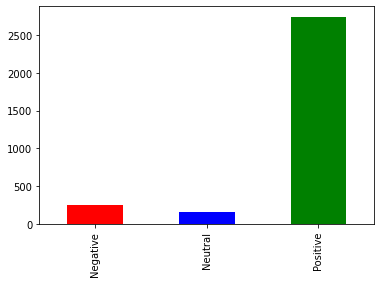

In [20]:
import matplotlib.pyplot as plt
df['sentiment'].value_counts().sort_index().plot.bar(color=['red', 'blue', 'green'])

**Splitting the Dataset**

In [21]:
x = df['verified_reviews'].values
y = df['sentiment'].values
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 0,stratify = y)

In [22]:
np.unique(y_train,return_counts=True)

(array(['Negative', 'Neutral', 'Positive'], dtype=object),
 array([ 205,  122, 2193]))

In [23]:
np.unique(y_test,return_counts=True)

(array(['Negative', 'Neutral', 'Positive'], dtype=object),
 array([ 52,  30, 548]))

**Pipeline**

*   Vectorization using TFIDF Vectorizer
*   Calling SVM Algorithm

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
text_model = Pipeline([('tfidf',TfidfVectorizer()),('model',SVC())])

In [25]:
text_model.fit(x_train,y_train)
y_pred = text_model.predict(x_test)
np.unique(y_pred,return_counts=True)

(array(['Negative', 'Neutral', 'Positive'], dtype=object),
 array([ 11,   8, 611]))

**Model Evaluation**

In [26]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy_score(y_pred,y_test)*100

89.84126984126985

In [27]:
confusion_matrix(y_pred,y_test)

array([[ 10,   1,   0],
       [  0,   8,   0],
       [ 42,  21, 548]])

In [28]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

    Negative       0.19      0.91      0.32        11
     Neutral       0.27      1.00      0.42         8
    Positive       1.00      0.90      0.95       611

    accuracy                           0.90       630
   macro avg       0.49      0.94      0.56       630
weighted avg       0.98      0.90      0.93       630



In [29]:
text_model.predict(['This product is amazing!'])

array(['Positive'], dtype=object)

In [30]:
import joblib
joblib.dump(text_model,'Sentiment_Analyser')

['Sentiment_Analyser']

**Create Web App**

In [31]:
!pip install streamlit --quiet
!pip install pyngrok==4.1.1 --quiet
from pyngrok import ngrok

     |████████████████████████████████| 8.2MB 12.8MB/s 
     |████████████████████████████████| 163kB 84.9MB/s 
     |████████████████████████████████| 4.2MB 53.6MB/s 
     |████████████████████████████████| 112kB 49.0MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 122kB 65.8MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.4 which is incompatible.


In [ ]:
!pip install htbuilder

In [ ]:
%%writefile app.py
import streamlit as st
import sklearn
import joblib

model = joblib.load('Sentiment_Analyser')
st.title('Sentiment Analyser')
ip = st.text_input('Enter your review: ')
op = model.predict([ip])
ans=op[0]
if st.button('Predict'):
  if ans == 'Positive':
      st.success("Positive :)")
  elif ans == 'Negative':
      st.error("Negative :(")
  elif ans== 'Neutral':
      st.warning("Neutral :|")

In [33]:
!nohup streamlit run app.py &
url=ngrok.connect(port='8501')
url

nohup: appending output to 'nohup.out'


'http://84f1b62c0b8c.ngrok.io'

In [34]:
!pip install pipreqs --quiet

In [35]:
!pipreqs /content

INFO: Successfully saved requirements file in /content/requirements.txt
